In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [2]:

import nltk
import string
from nltk.stem import LancasterStemmer
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

Loading Data

In [3]:
#Training data
train_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [5]:
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
#Test data
test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           54200 non-null  int64 
 1   Title        54200 non-null  object
 2   Description  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [8]:
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


Preprocessing

In [9]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [10]:
duplicated_count = train_data.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  0


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [13]:
newStopWords = ['u','go','got','via','or','ur','us','in','i','let','the','to','is','amp','make','one','day','days','get']
stopwords.extend(newStopWords)

In [14]:
def data_processing(text):
    text= text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stopwords]
    return " ".join(filtered_text)

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
train_data['Clean_text'] = train_data['Description'].apply(data_processing)
test_data['Clean_text'] = test_data['Description'].apply(data_processing)

In [17]:
train_data.head(5)

,Title,Genre,Description,Clean_text
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father ends meet edith twin si...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers unrecovered bodies ground z...


In [18]:
test_data.head(5)

,Id,Title,Description,Clean_text
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",lr brane loves life car apartment job especial...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march 1964 quico naughty child three bel...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,year life albin family shepherds north transyl...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother 10 years seri...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...


In [19]:
# Types of genres
train_data['Genre'].value_counts()

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

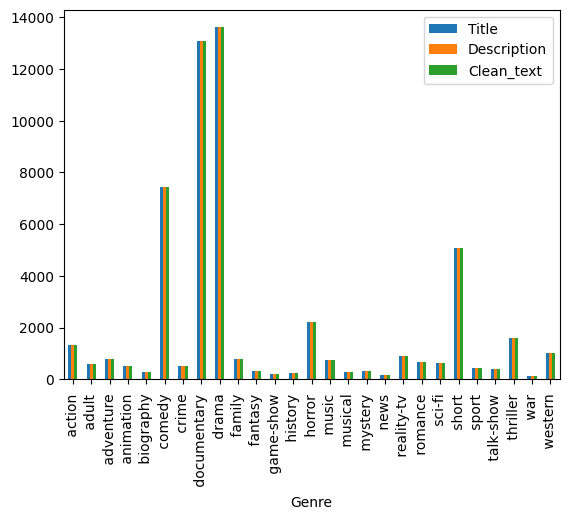

In [20]:
# Plotting sentiment value counts
train_data.groupby('Genre').count().plot(kind='bar')
plt.show()

In [21]:
vector = TfidfVectorizer()

x_train = vector.fit_transform(train_data["Clean_text"])
x_test = vector.transform(test_data["Clean_text"])

In [22]:
x = x_train
y = train_data["Genre"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)

In [23]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (43371, 150736)
Size of y_train:  (43371,)
Size of x_test:  (10843, 150736)
Size of y_test:  (10843,)


Naive Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(x_train,y_train)

NB_prediction = naiveByes_clf.predict(x_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("Training accuracy Score    : ",naiveByes_clf.score(x_train,y_train))
print("Test accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

Training accuracy Score    :  0.4688155680062715
Test accuracy Score :  0.4449875495711519


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.00      0.00      0.00         0
       adult        0.00      0.00      0.00         0
   adventure        0.00      0.00      0.00         0
   animation        0.00      0.00      0.00         0
   biography        0.00      0.00      0.00         0
      comedy        0.04      0.61      0.07        83
       crime        0.00      0.00      0.00         0
 documentary        0.90      0.54      0.67      4465
       drama        0.88      0.38      0.53      6294
      family        0.00      0.00      0.00         0
     fantasy        0.00      0.00      0.00         0
   game-show        0.00      0.00      0.00         0
     history        0.00      0.00      0.00         0
      horror        0.00      0.00      0.00         0
       music        0.00      0.00      0.00         0
     musical        0.00      0.00      0.00         0
     mystery        0.00      0.00      0.00         0
        n

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


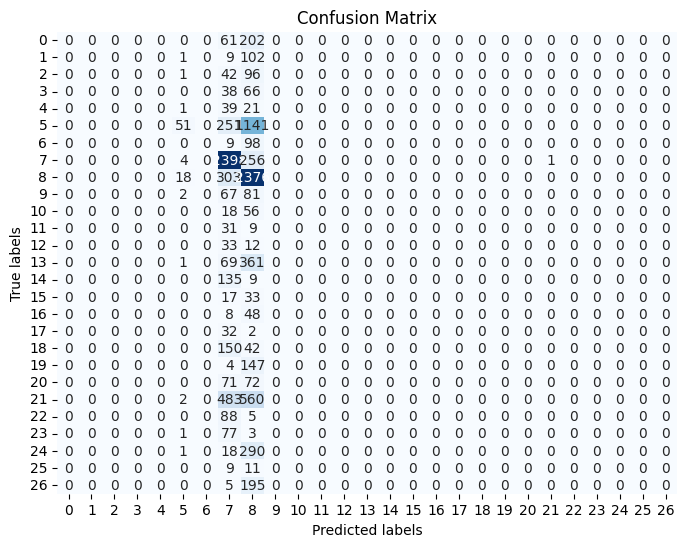

In [25]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, NB_prediction)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(x_train, y_train)

logreg_prediction = logreg.predict(x_test)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(x_train,y_train))
print("Test accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy Score    :  0.7079384842406217
Test accuracy Score :  0.5787143779396846


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.21      0.62      0.31        88
       adult        0.18      0.87      0.30        23
   adventure        0.12      0.47      0.18        34
   animation        0.01      1.00      0.02         1
   biography        0.00      0.00      0.00         0
      comedy        0.59      0.52      0.55      1610
       crime        0.01      0.50      0.02         2
 documentary        0.87      0.65      0.74      3581
       drama        0.81      0.53      0.64      4141
      family        0.05      0.50      0.10        16
     fantasy        0.00      0.00      0.00         0
   game-show        0.33      0.93      0.48        14
     history        0.00      0.00      0.00         0
      horror        0.53      0.67      0.60       342
       music        0.35      0.67      0.46        75
     musical        0.00      0.00      0.00         0
     mystery        0.00      0.00      0.00         0
        n

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


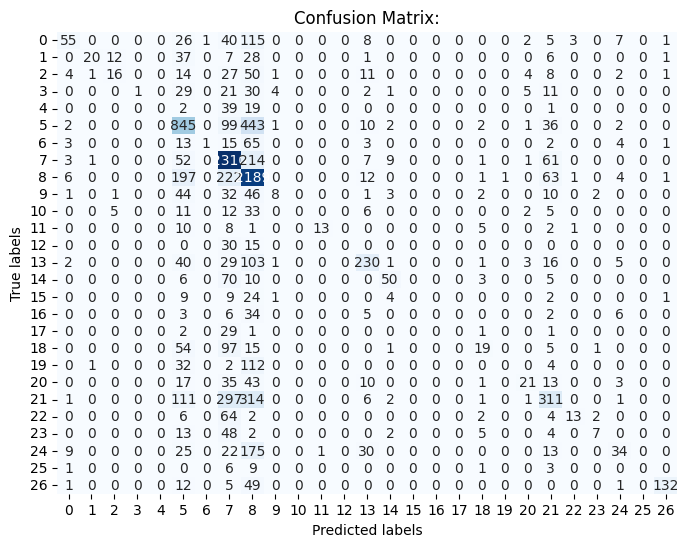

In [27]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, logreg_prediction)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

SVC

In [28]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(x_train, y_train)

svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Training accuracy Score    : ",svc.score(x_train,y_train))
print("Test accuracy Score : ",svc_acc )
print(classification_report(svc_pred,y_test))

Training accuracy Score    :  0.9860275299163035
Test accuracy Score :  0.588305819422669
               precision    recall  f1-score   support

      action        0.34      0.49      0.40       182
       adult        0.43      0.74      0.54        65
   adventure        0.22      0.43      0.29        72
   animation        0.11      0.42      0.17        26
   biography        0.00      0.00      0.00         1
      comedy        0.58      0.52      0.55      1626
       crime        0.06      0.30      0.09        20
 documentary        0.82      0.69      0.75      3164
       drama        0.73      0.56      0.64      3502
      family        0.15      0.38      0.22        60
     fantasy        0.03      0.14      0.05        14
   game-show        0.68      0.84      0.75        32
     history        0.02      0.50      0.04         2
      horror        0.67      0.65      0.66       441
       music        0.57      0.66      0.61       125
     musical        0.04     

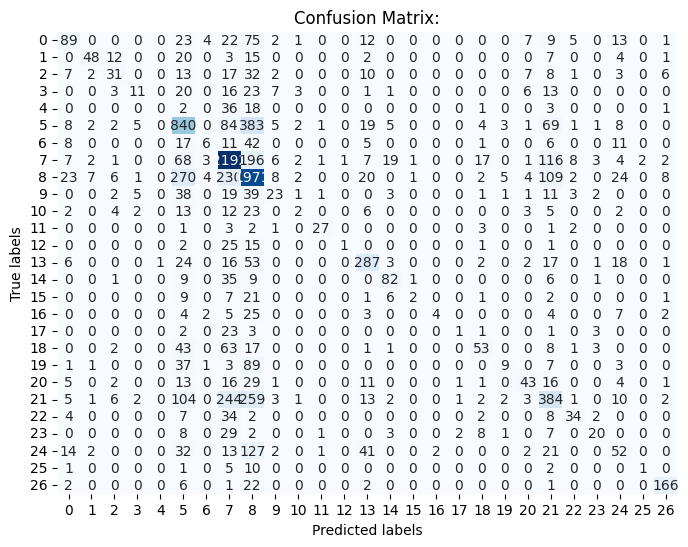

In [29]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, svc_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

In [30]:
models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'Naive Bayes',
              'Support Vector'],
    'Test accuracy': [logreg_accuracy,
              NB_accuracy,
              svc_acc]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
2,Support Vector,0.588306
0,Logistic Regression,0.578714
1,Naive Bayes,0.444988
